# Проект: HR-аналитика


# Описание проекта
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

# Цели проекта 
- Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# План исследования
1. Подготовка данных - загрузка и изучение общей информации из предоставленных датасетов.
2. Предобработка данных - поиск пропущенных значений, дубликатов, замена названий столбцов, поиск аномальных значений.
3. Исследовательский анализ данных - изучение распределений количественных и категориальных признаков в датасетах, определение корреляции между признаками(EDA).
4. Подготовка данных - создание пайплайна с подготовкой признаков.
5. Обучение моделей. В первой задаче - линейная и дерево решений, во второй перебор моделей. Проверка сооответствия заявленному в задании уровню метрик. 
6. Оформление выводов. 


## Подготовка данных

### Сначала загрузим необходимые библиотеки и данные

In [1]:
!pip install -q imblearn
!pip install -q phik
!pip install -q scikit-learn
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats
import optuna
import phik
import shap


#Графики
import seaborn as sns
import matplotlib.pyplot as plt
from re import template
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from phik.report import plot_correlation_matrix




# Модели МО
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Разбивка данных + обработка признаков 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Метрики для Линейной Регрессии
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Метрики для Логистической Регрессии
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn. metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score,make_scorer

# Для подбора гиперпараметров 
from optuna import distributions
from optuna.integration import OptunaSearchCV

# Интерпритация модели
from sklearn.inspection import permutation_importance



# Для создания пайплайна 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [3]:
# Сразу зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Загрузим файлы
X_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Изучим предметно данные

In [5]:
X_train.sample(5)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1730,775275,purchasing,junior,low,1,no,no,5,19200,0.67
2208,690132,hr,sinior,high,9,yes,no,5,70800,0.76
1709,811953,purchasing,junior,low,2,no,no,3,19200,0.52
3178,585770,purchasing,sinior,high,2,no,no,4,79200,0.68
1589,973585,sales,junior,low,1,no,no,3,14400,0.17


In [6]:
X_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
X_train.info()
X_train.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [8]:
X_test.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
933,125082,hr,junior,high,2,no,yes,2,32400
936,563825,marketing,junior,medium,1,no,no,5,31200
662,464449,purchasing,junior,medium,2,no,no,4,30000
1507,877828,sales,junior,high,1,no,no,3,36000
192,179280,purchasing,junior,high,1,no,no,4,36000


In [9]:
X_test.info()
X_test.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')

In [10]:
y_test.sample(5)

,id,job_satisfaction_rate
267,302852,0.92
1676,245828,0.67
720,826000,0.54
160,604783,0.46
1012,463463,0.57


In [11]:
y_test.info()
y_test.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Index(['id', 'job_satisfaction_rate'], dtype='object')

Описание признаков:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

### Выводы
- У нас есть тестовая и тренировочные выборки. 
- в таблицах X_train и X_test есть пропуски в столбцах dept и level. Их заполним далее;
- типы данных во всех столбцах соответствуют действительности;
- названия столбцов соотеветсвуют общепринятым правилам;
- необходимо проверить данные на явные и неявные дубликаты;

## Предобработка данных

In [12]:
# Массив с датасетами
arr = [X_train,X_test,y_test]

In [13]:
# Для поиска дублей
def find_double(arr):
    for df in arr: 
        print(df.duplicated().sum())

In [14]:
find_double(arr)

0
0
0


In [15]:
def cat_col_uniq(arr):
    for df in arr:
        cat_col_names = df.select_dtypes(exclude='number').columns.tolist()
        for col in cat_col_names:
            print(df[col].unique())

In [16]:
cat_col_uniq(arr)

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [17]:
cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
cat_col_names

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [18]:
X_train['salary'].unique()

array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200])

In [19]:
X_train['job_satisfaction_rate'].unique()

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

In [20]:
X_train['employment_years'].unique()

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

In [21]:
X_train['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4])

In [22]:
# Можно, конечно, sinior поменять на senior, но большой разницы не вижу. 
# Вижу пропуски, но это обработаем в пайплайне.
# Посмотрим точечные дубликаты по id, так как 1 id = 1 человеку 
X_train.duplicated(subset=['id']).sum()

0

In [23]:
X_test.duplicated(subset=['id']).sum()

0

In [24]:
y_test.duplicated(subset=['id']).sum()

0

In [25]:
# Строим пайплайн по замене значений на самое частое значние. Пропусков не много, должно быть не критично.
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [26]:
X_train[X_train.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [27]:
#Выделим столбцы с пропусками
nan_cols = ['level','dept']

In [28]:
X_train[nan_cols] = imputer_pipe.fit_transform(X_train[nan_cols])


In [29]:
#проверка
X_train[X_train.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


In [30]:
# аналогично в тестовых данных
X_test[nan_cols] = imputer_pipe.transform(X_test[nan_cols])


In [31]:
#проверка
X_test[X_test.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


### Вывод по предобработке данных:
- Посмотрели что нет полных дублей и точечных дублей по id. 
- Нашли 4 + 2 пропуска, заменили их с помощью пайплайна(SimpleImputer) на самое популярное значение. 
- Можно приступать к следующему этапу


## Исследовательский анализ данных

### С прошлых работ у меня есть функуции для количественных, категориальных и количественных с дискретной природой признаков + тест Шапиро-Уилка. Добавим их:


In [32]:
def analyze_numerical_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика для признака: {feature}")
        display(df[feature].describe())
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Гистограмма
        axes[0].set_title(f'Распределение {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Количество')

        if target:
            sns.histplot(data=df, x=feature, hue=target, kde=True, bins=20, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, bins=20, ax=axes[0])
        
        # Boxplot
        axes[1].set_title(f'Boxplot для {feature}', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, x=feature, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
        print("-" * 60)

In [33]:
#для категориальных
def analyze_categorical_features(df, features):
    for feature in features:
        print(f"Числовые данные для {feature}:")
        display(df[feature].value_counts())
        
        plt.figure(figsize=(8, 4))
        sns.countplot(y=df[feature], order=df[feature].value_counts().index)
        plt.title(f"Распределение категорий {feature}")
        plt.show()
        print("-" * 50)

In [34]:
# добавим функцию для дискретных величин
def analyze_discrete_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика по дискретному признаку: {feature}")
        display(df[feature].value_counts().sort_index())
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))


        if target:
            sns.countplot(data=df, x=feature, hue=target,
                          order=sorted(df[feature].dropna().unique()),
                          ax=axes[0])
        else:
            sns.countplot(data=df, x=feature,
                          order=sorted(df[feature].dropna().unique()),
                          ax=axes[0])
        # меняем распределение значений — countplot
        axes[0].set_title(f'Распределение значений {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Количество')
            
        axes[0].tick_params(axis='x')

        # ящик с усами по target ))
        axes[1].set_title(f'Boxplot: {feature} по целевому признаку', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, y=feature, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
        print("-" * 60)


In [35]:
# Добавил тест Шапиро-Уилка
def norm_test_all(data, features, alpha=0.05):
    for feature in features:
        print(f"\n📊 Анализ признака: {feature}")
        
        # Тест Шапиро-Уилка
        stat, p = stats.shapiro(data[feature].dropna())
        print(f"Shapiro-Wilk test: stat={stat:.3f}, p-value={p:.3f}")
        if p > alpha:
            print("✅ Распределение похоже на нормальное (не отвергаем H0)")
        else:
            print("❌ Распределение отличается от нормального (отвергаем H0)")
        
        # Построим графики
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        sns.histplot(data[feature].dropna(), kde=True, ax=axs[0])
        axs[0].set_title('Гистограмма')
        axs[0].set_ylabel('Частота')
        axs[0].set_xlabel(feature)

        stats.probplot(data[feature].dropna(), dist='norm', plot=axs[1])
        axs[1].set_title('Q-Q plot')

        plt.suptitle(f'Анализ признака: {feature}', fontsize=14)
        plt.tight_layout()
        plt.show()

### Будем анализировать датасеты по порядку. 

#### Распределим признаки для X_train:

In [36]:
#Количественные 
quant_features = [
    'salary',
    'job_satisfaction_rate'
    
]

In [37]:
# Категориальные 
cat_features = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
    
]


In [38]:
discrete_features = [
    'supervisor_evaluation',
    'employment_years'
]

📊 Статистика для признака: salary


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

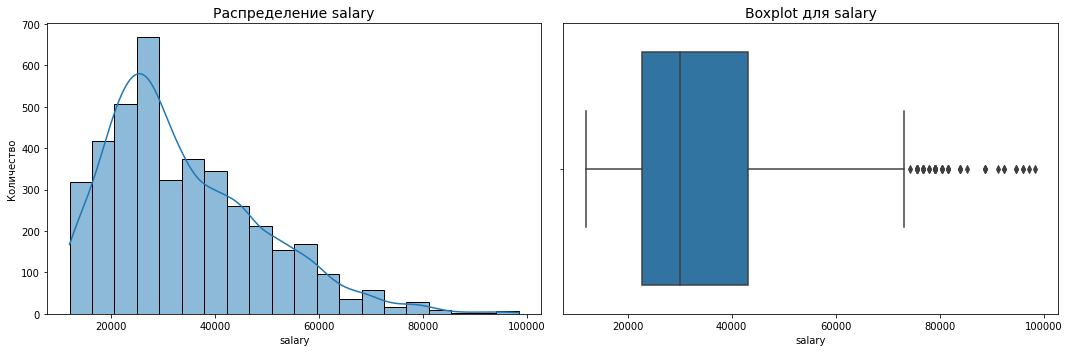

------------------------------------------------------------
📊 Статистика для признака: job_satisfaction_rate


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

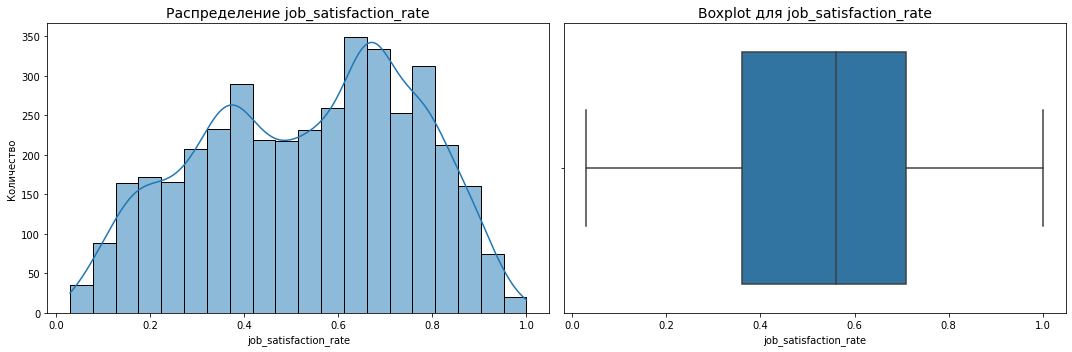

------------------------------------------------------------


In [39]:
analyze_numerical_features(X_train, quant_features)

Числовые данные для dept:


sales         1518
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

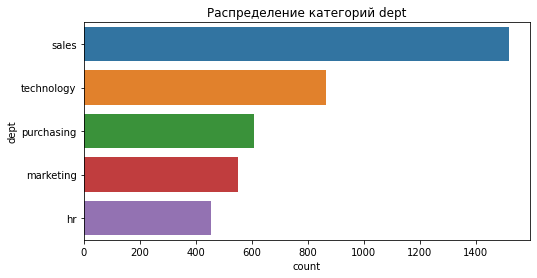

--------------------------------------------------
Числовые данные для level:


junior    1898
middle    1744
sinior     358
Name: level, dtype: int64

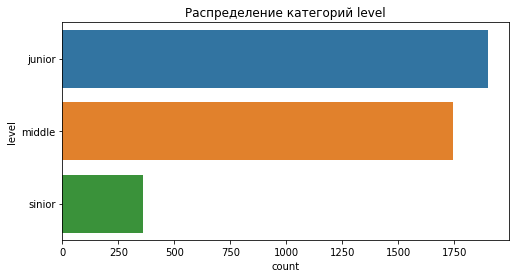

--------------------------------------------------
Числовые данные для workload:


medium    2066
low       1200
high       734
Name: workload, dtype: int64

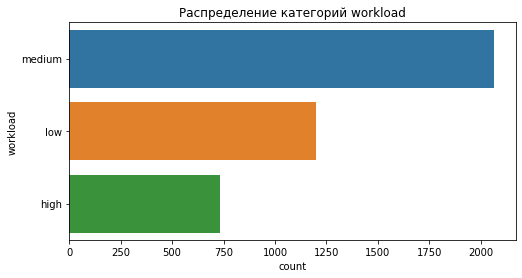

--------------------------------------------------
Числовые данные для last_year_promo:


no     3880
yes     120
Name: last_year_promo, dtype: int64

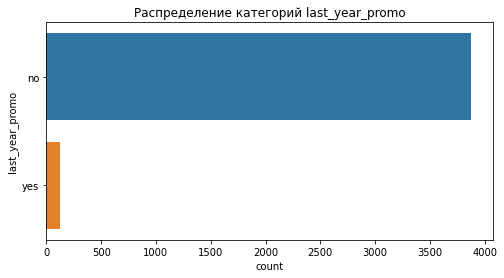

--------------------------------------------------
Числовые данные для last_year_violations:


no     3441
yes     559
Name: last_year_violations, dtype: int64

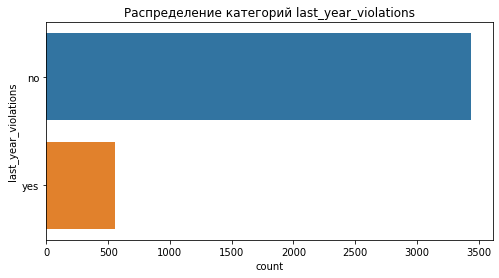

--------------------------------------------------


In [40]:
analyze_categorical_features(X_train,cat_features)

📊 Статистика по дискретному признаку: supervisor_evaluation


1     201
2     387
3    1263
4    1603
5     546
Name: supervisor_evaluation, dtype: int64

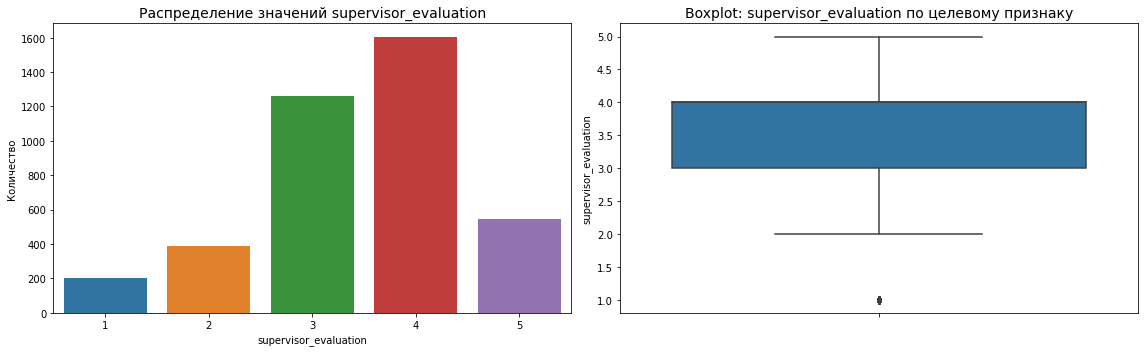

------------------------------------------------------------
📊 Статистика по дискретному признаку: employment_years


1     966
2     785
3     483
4     384
5     380
6     287
7     301
8     193
9     130
10     91
Name: employment_years, dtype: int64

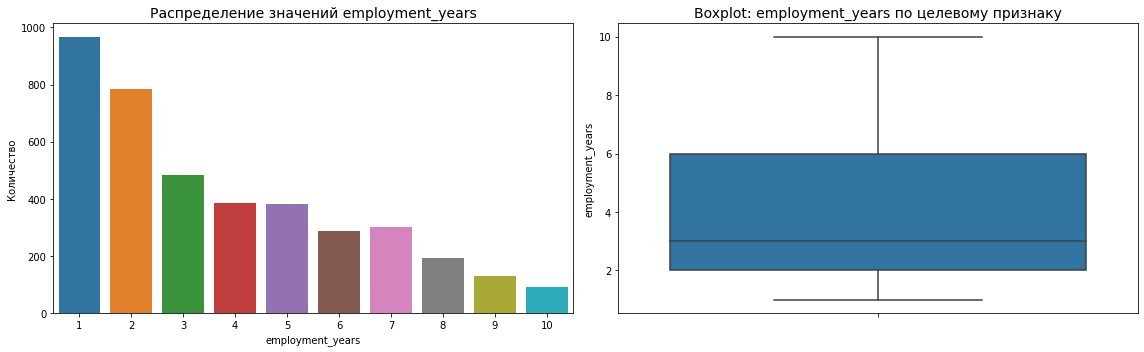

------------------------------------------------------------


In [41]:
analyze_discrete_features(X_train,discrete_features)

#### Небольшой промежуточный вывод: 
- Так как у нас по факту один датасет, разбитый на тестовую, тренировочную выборки + отдельно выведенный целевой признак тестовой выбори, то и выводы будут после. 

In [42]:
# Поправим для тестовой выборки :
quant_features = [
    'salary'
]

📊 Статистика для признака: salary


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

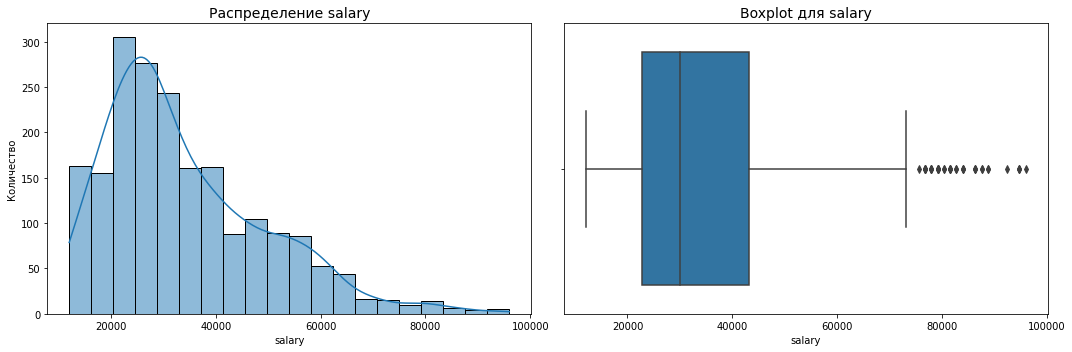

------------------------------------------------------------


In [43]:
analyze_numerical_features(X_test, quant_features)

Числовые данные для dept:


sales         765
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

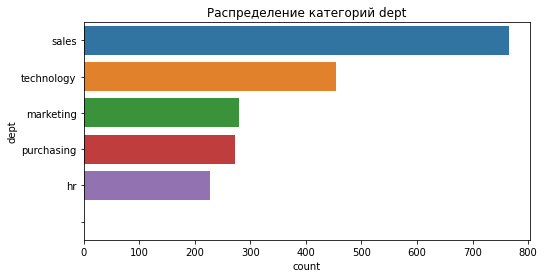

--------------------------------------------------
Числовые данные для level:


junior    975
middle    854
sinior    171
Name: level, dtype: int64

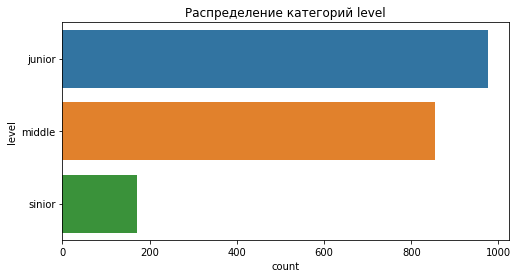

--------------------------------------------------
Числовые данные для workload:


medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

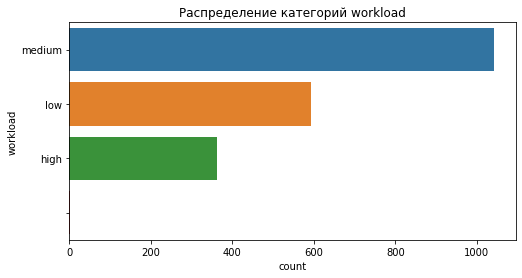

--------------------------------------------------
Числовые данные для last_year_promo:


no     1937
yes      63
Name: last_year_promo, dtype: int64

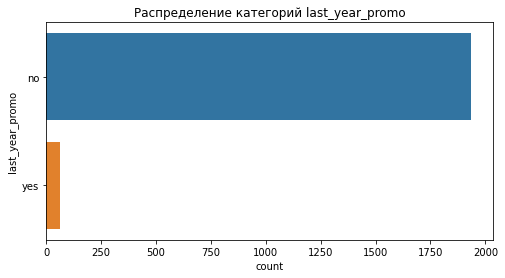

--------------------------------------------------
Числовые данные для last_year_violations:


no     1738
yes     262
Name: last_year_violations, dtype: int64

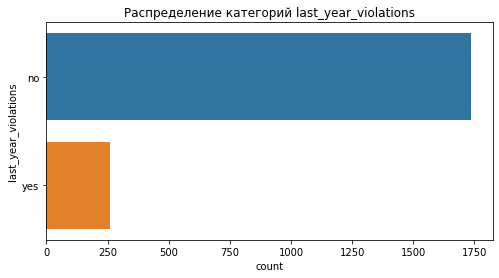

--------------------------------------------------


In [44]:
analyze_categorical_features(X_test,cat_features)

📊 Статистика по дискретному признаку: supervisor_evaluation


1     88
2    196
3    575
4    857
5    284
Name: supervisor_evaluation, dtype: int64

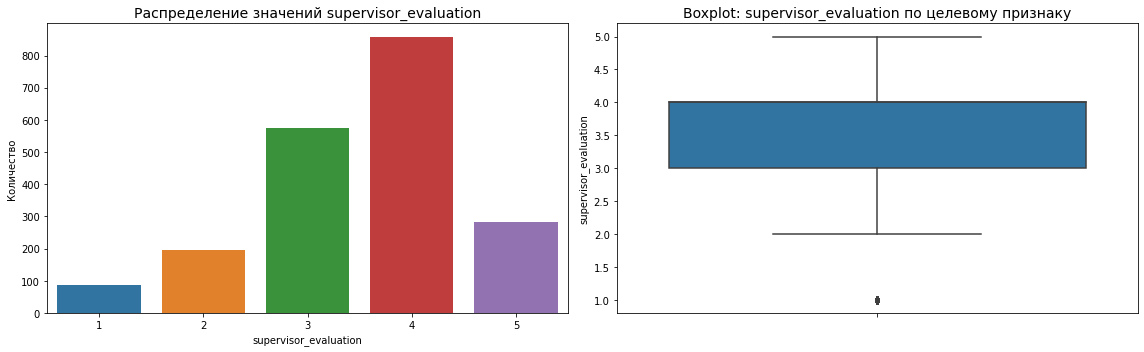

------------------------------------------------------------
📊 Статистика по дискретному признаку: employment_years


1     522
2     374
3     234
4     187
5     179
6     138
7     174
8      91
9      66
10     35
Name: employment_years, dtype: int64

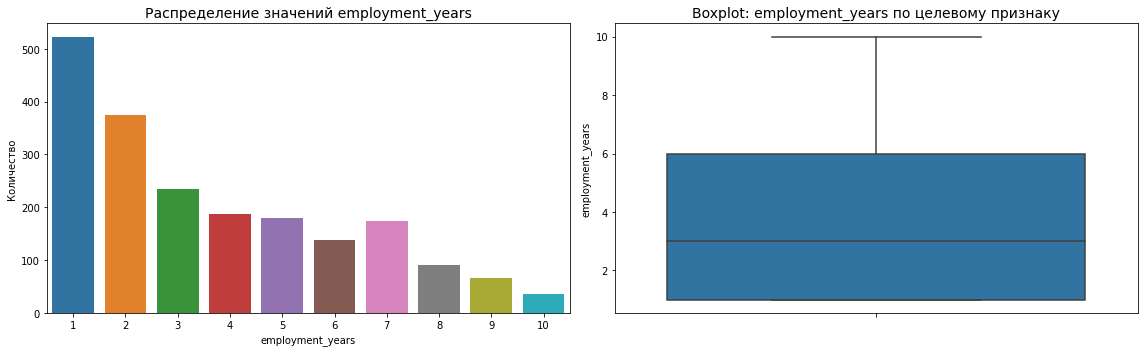

------------------------------------------------------------


In [45]:
analyze_discrete_features(X_test,discrete_features)

📊 Статистика для признака: job_satisfaction_rate


count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

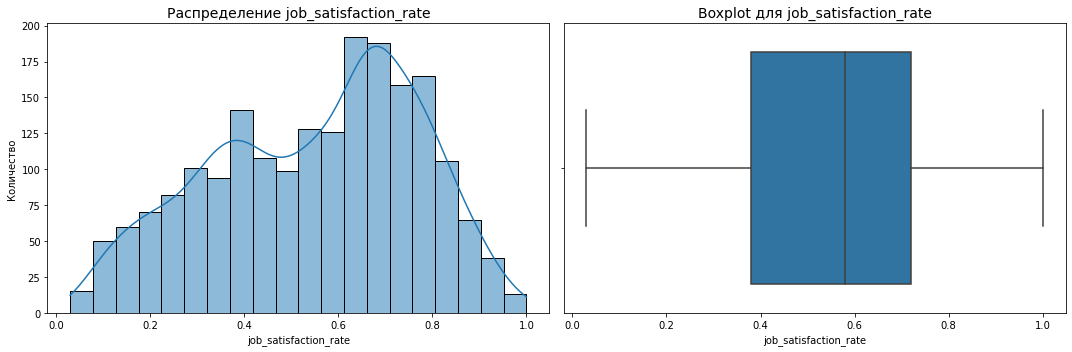

------------------------------------------------------------


In [46]:
# Анализ целевого
analyze_numerical_features(y_test, ['job_satisfaction_rate'])


📊 Анализ признака: salary
Shapiro-Wilk test: stat=0.939, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


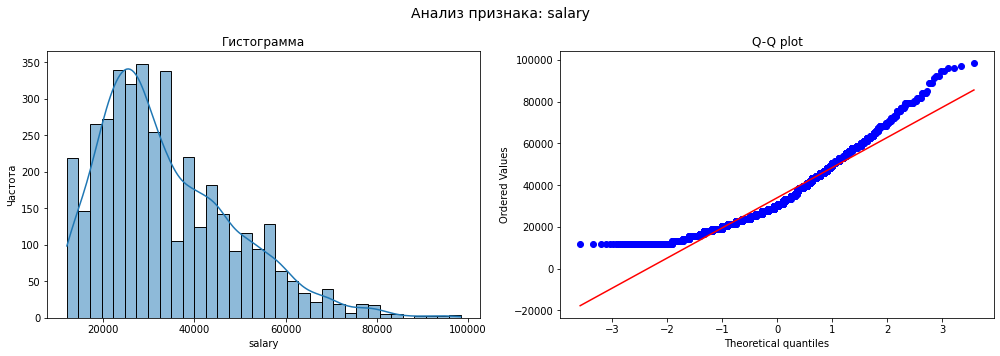

In [47]:
# Посомтрим на нормальность распределения 
norm_test_all(X_train,quant_features)


📊 Анализ признака: salary
Shapiro-Wilk test: stat=0.926, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


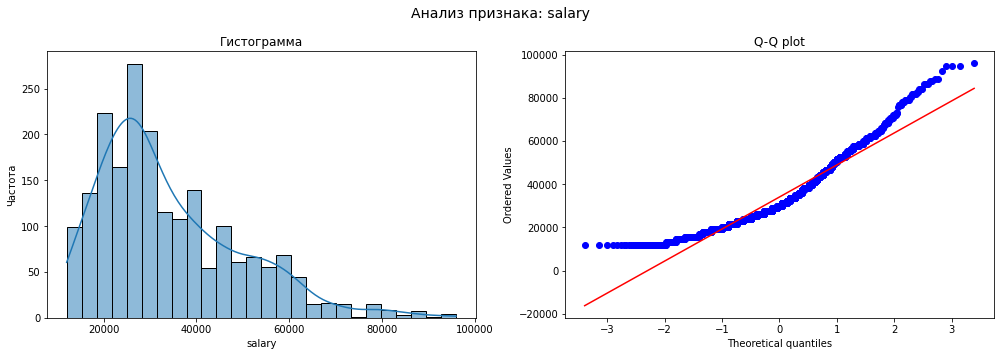

In [48]:
norm_test_all(X_test,quant_features)


📊 Анализ признака: job_satisfaction_rate
Shapiro-Wilk test: stat=0.970, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


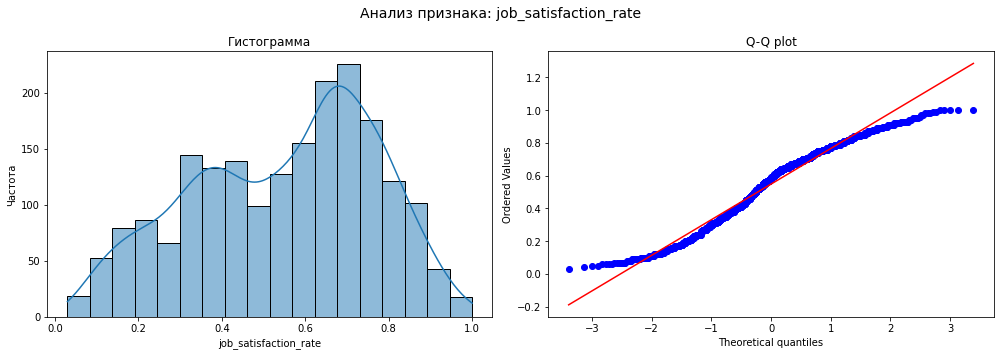

In [49]:
norm_test_all(y_test,['job_satisfaction_rate'])

#### Выводы:
- Расрпделение на графиках X_train, X_test, y_test идентично. Это один большой датасет разбитый на тестовую и тренировочную выборки + у теста целевой признак выделен в отдельный датасет. 
-  *salary* - визуально имеет нормальное расрпедление со смещением влево. Большой хвост вправо и выбросы судя по диаграмме boxplot. Однако убирать мы их не будем, так как логически есть высооплачиваемый персонал в каждой компании(высококвалифицированные спецы + высший менеджмент)
- *job_satisfaction_rate* - целевой признак,имеет визуально нормальное распредление со смещениеим вправо и без выбросов. Означает, что большинство скорее удовлетворено.  
- Оба признака не прошли тест Шапиро-Уилка. Распределение близко к нормальному, но все же таковым не является(stat находится в диапазон от 0.926 до 0.970 )
- *supervisor_evaluation* - плохая оценка(1) по графику с усами является выбросом. Удалять не будем. Преимущественно оценка 4& 
- *dept* - больше всего людей в продажах, меньше всего в кадрах. Тут выводы можно сделать о специфике работы компании. 
- *level* - больше всего начинающих специалистов, чуть меньше мидлов и совсем немного страших. 
- *workload* - у большинства нагрузка средняя, далее малая загрузка, и где-то 1/4 сильно загружена.
- *employment_years* - большинство сотрудников работает год. 
- *last_year_promo* - очень маленький процент сотрудников повышали в прошлом году.
- *last_year_violations* -  чуть больше людей наруашало трудовой договор.



### Корреляционный анализ

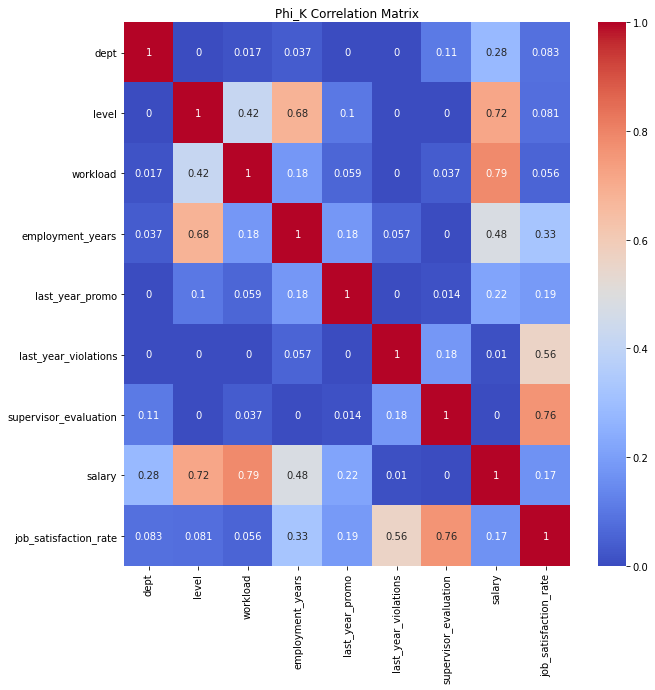

In [50]:
# Будем смотреть только тренировочный датасет, этого хватит что бы понять

#вычисление матрицы корреляции
corr_matrix = X_train.drop(['id'], axis=1).phik_matrix(interval_cols=['salary', 
                                                                   'job_satisfaction_rate'])


#визуализация матрицы корреляции 
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

#### Вывод. Имеется высокая корреляция между:
- уровнем занимаемой должности и длительностью работы в компании
- уровнем занимаемой должности и зарплатой
- уровнем загруженности сотрудника и зарплатой
- Также имеется высокая корреляция между целевым признаком и оценкой качества работы и нарушениями трудового договора. 
- Мультиколлинеарности не обнаружено, ничего удалять не будем.

## Подготовка данных

### Следуя брифу и здравому смыслу, будем использовать модели линейной регрессии и дерево решений.  Так же обозначим: 
- целевой признак: job_satisfaction_rate
- workload, level - ранговые признаки. Их кодируем через OrdinalEncoder. 
- dept, last_year_promo,last_year_violations - через OneHotEncoding. 
- количественные признаки: salary, employment_years, supervisor_evaluation - будем масштабировать.
- В тренировочной выборке выделим целевой, и убрем id во всех 

In [51]:
#забекапимся
X_train_backup=X_train

In [52]:
X_train=X_train_backup.drop('id', axis=1)

In [53]:
X_test = X_test.sort_values(by='id').reset_index(drop=True)
X_test.head()


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [54]:
y_test = y_test.sort_values(by='id').reset_index(drop=True)
y_test.head()

,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69


In [55]:
y_train = X_train['job_satisfaction_rate']
X_train = X_train.drop('job_satisfaction_rate', axis=1)
X_test = X_test.drop('id', axis=1)
y_test = y_test['job_satisfaction_rate']

In [56]:
#создание списков количественных и категориальных для пайплайна
num_col = ['employment_years',  
           'salary']

ord_col = ['level',
           'workload',
           'supervisor_evaluation']

ohe_col = ['dept',
           'last_year_promo', 
           'last_year_violations']

In [57]:
#Pipeline для кодирования категориальных признаков
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

In [58]:
#Pipeline для кодирования категориальных ранговых признаков
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5]
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [59]:
# Pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [60]:
# Итоговый Pipeline: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [61]:
#Параметры для передачи GridSearchCV/RandomizedSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder и перебором гиперпараметров

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
] 

#### Создание метрики SMAPE

In [62]:
# создание собственной метрики для оценки модели
def SMAPE(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    smape = 2 * np.abs(y_true - y_pred) / np.where(denominator == 0, 1, denominator)
    return 100 * np.mean(smape)

SMAPE_score = make_scorer(SMAPE, greater_is_better=False)


In [63]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=SMAPE_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

## Обучение модели

In [64]:
# Обучаем модель на тренировочных данных
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[...
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 21),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(SMAPE, greater_is_better=False, response_method='predict'))

In [65]:
# Выводим предметные итоги:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели :', round(-randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                            

In [66]:
# Используем модель на тестовых данных
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {round(SMAPE(y_test, y_test_pred), 2)}')

Метрика SMAPE на тестовой выборке: 14.53


In [67]:
# Можно собрать датафрейм и посмотреть на все результаты 
# Наша метрика в столбце mean_test_score, отрицательная она потому что
# greater_is_better=False 
pd.DataFrame(randomized_search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.033024,0.003896,0.012429,0.000755,StandardScaler(),13.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.065363,-15.382875,-15.177052,-15.188200,-13.885784,-14.939855,0.536847,1
2,0.031858,0.001329,0.013057,0.000759,StandardScaler(),14.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.143859,-15.822058,-15.624044,-15.290128,-13.514836,-15.078985,0.817875,2
7,0.031929,0.002527,0.014463,0.002549,StandardScaler(),18.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.039406,-16.230051,-15.485103,-15.350805,-13.886285,-15.198330,0.763761,3
3,0.032019,0.001644,0.012408,0.000991,StandardScaler(),17.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.159696,-16.155653,-15.363285,-15.584541,-13.831196,-15.218874,0.769581,4
5,0.036444,0.004491,0.012619,0.000603,StandardScaler(),20.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.283740,-16.144735,-15.459823,-15.729335,-14.015654,-15.326657,0.716897,5
8,0.031589,0.005788,0.011698,0.000450,StandardScaler(),6.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-19.537270,-18.582269,-18.875862,-19.233848,-18.386427,-18.923135,0.419567,6
4,0.026443,0.002675,0.011547,0.000593,MinMaxScaler(),6.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-19.537270,-18.584838,-18.875862,-19.233848,-18.386427,-18.923649,0.419151,7
1,0.024830,0.001498,0.011992,0.001708,passthrough,3.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-22.760626,-22.919857,-22.905060,-22.466722,-20.697532,-22.349959,0.842107,8
0,0.029687,0.003579,0.012487,0.001301,StandardScaler(),2.0,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-24.406881,-24.556504,-23.604857,-23.679547,-21.835983,-23.616754,0.967746,9
9,0.140906,0.066013,0.091465,0.060087,StandardScaler(),NaN,LinearRegression(),"{'preprocessor__num': StandardScaler(), 'model...",-27.729320,-29.236837,-27.887397,-28.323157,-25.616157,-27.758574,1.192595,10


####  Я столкнулся с проблемой, что получал хорошую метрику удовлетворяющую условию на тренировочной выборке. Но получал x3 от нее при тестовой. Я думал дело в дубликатах, но оказалось дело в id в тестовой выборке. Поправил и метрика на тестовой выборке стала нормальной. Так же у меня была ошибка в определении признаков: 
- supervisor_evaluation я изначально отнес к количественным признакам, а это не так. В Выводах чуть детальней. 

 ### Переходим к выводам. Но сначала оценим признаки модели через shap. Так как лучшая модель DecisionTreeRegressor, то использовать будем TreeExplainer. 

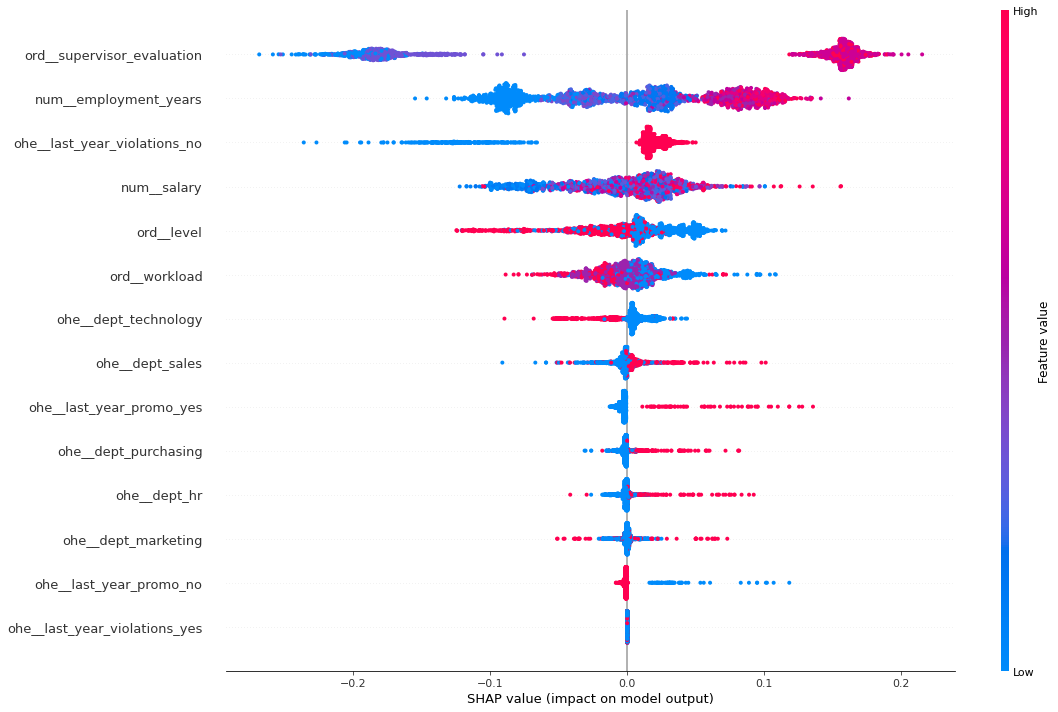

In [68]:
# Преобразуем обучающие данные
X_train_shap = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_shap = pipe_final.named_steps['preprocessor'].transform(X_test)

# Получаем финальную модель из RandomizedSearch
model = randomized_search.best_estimator_.named_steps['models']

# Получаем имена признаков
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_shap_total = pd.DataFrame(X_test_shap, columns=feature_names)

# Создаём объяснитель для деревьев
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_test_shap_total)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_test_shap_total, feature_names=feature_names, plot_size=(16, 10))


In [69]:
# Хочется более точных цифр
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': mean_abs_shap})
shap_df.sort_values('mean_abs_shap', ascending=False).head(10)

,feature,mean_abs_shap
11,ord__supervisor_evaluation,0.167734
12,num__employment_years,0.059468
7,ohe__last_year_violations_no,0.033231
13,num__salary,0.032454
9,ord__level,0.026830
10,ord__workload,0.017489
4,ohe__dept_technology,0.010860
3,ohe__dept_sales,0.006775
6,ohe__last_year_promo_yes,0.004433
2,ohe__dept_purchasing,0.003496


## Вывод:
   - Лучшая модель: дерево решений с глубиной 13 и масштабированием количественных признаков через StandardScaler().
   - Следуя условию задачи, мы написали собственную метрику SMAPE и на тестовой выборке она равна 14.52, что так же соответствует условию задачи(<=15)
   - Самым весомым признаком оказался ord__supervisor_evaluation. Хотя изначально у меня была логическая ошибка, что я отнес его к количественным признакам. После исправления ничего не поменялось, что объясняется тем, что у нас дерево, которое не зависит от этого порядка. 
   - Логике признак тоже поддается, если руководитель ставит хорошую оценку, значит его устраивает как работает сотрудник.
   - Второй по знакчимости признак employment_years, что тоже поддается логике: если человек долго работает, то его все устраивает. 
   - Предполагаю, что дерево справилось лучше, так как есть нелинейные зависимости. 

# Задача 2: предсказание увольнения сотрудника из компании


## Загрузка данных и изучение


In [70]:
X_train_2 = pd.read_csv('/datasets/train_quit.csv')
X_test_2 = pd.read_csv('/datasets/test_features.csv')
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')
arr = [X_train_2,X_test_2,y_test_2]

In [71]:
# Напишу функцию для беглого знакомства
def quick_eda_report(df):
    
        print(f'\n{"="*50}\n📊 Анализ датасета: \n{"="*50}')
        
        print('\n🔹 Размерность:', df.shape)
        
        print('\n🔹 Типы данных и информация:')
        display(df.info(verbose=False, memory_usage='deep'))
        
        print('\n🔹 Первые 5 строк:')
        display(df.head())

        print('\n🔹 Случайные 5 строк:')
        display(df.sample(5, random_state=42))

        print('\n🔹 Кол-во дубликатов:', df.duplicated().sum())
        
        print('\n🔹 Пропуски по столбцам:')
        nulls = df.isnull().sum()
        display(nulls[nulls > 0].sort_values(ascending=False))

        print('\n' + '-'*50)

In [72]:
quick_eda_report(X_train_2)



📊 Анализ датасета: 

🔹 Размерность: (4000, 10)

🔹 Типы данных и информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 10 entries, id to quit
dtypes: int64(4), object(6)
memory usage: 1.5 MB


None


🔹 Первые 5 строк:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



🔹 Случайные 5 строк:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
555,862161,sales,middle,high,6,yes,no,4,52800,no
3491,255595,sales,middle,medium,4,no,no,4,38400,no
527,205797,sales,junior,high,1,no,no,4,34800,no
3925,515388,sales,junior,low,2,no,no,4,15600,no
2989,590294,technology,junior,low,1,no,no,4,15600,yes



🔹 Кол-во дубликатов: 0

🔹 Пропуски по столбцам:


Series([], dtype: int64)


--------------------------------------------------


In [73]:
quick_eda_report(X_test_2)



📊 Анализ датасета: 

🔹 Размерность: (2000, 9)

🔹 Типы данных и информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 9 entries, id to salary
dtypes: int64(4), object(5)
memory usage: 662.0 KB


None


🔹 Первые 5 строк:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



🔹 Случайные 5 строк:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1860,112724,marketing,middle,low,5,no,yes,3,25200
353,509518,sales,middle,low,3,no,no,4,19200
1333,687861,purchasing,middle,high,7,no,no,5,55200
905,616289,sales,middle,medium,4,no,no,4,38400
1289,355227,technology,junior,medium,1,no,no,4,31200



🔹 Кол-во дубликатов: 0

🔹 Пропуски по столбцам:


dept     2
level    1
dtype: int64


--------------------------------------------------


In [74]:
quick_eda_report(y_test_2)



📊 Анализ датасета: 

🔹 Размерность: (2000, 2)

🔹 Типы данных и информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2 entries, id to quit
dtypes: int64(1), object(1)
memory usage: 131.5 KB


None


🔹 Первые 5 строк:


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



🔹 Случайные 5 строк:


,id,quit
1860,268896,no
353,384590,no
1333,530409,no
905,753246,no
1289,603262,no



🔹 Кол-во дубликатов: 0

🔹 Пропуски по столбцам:


Series([], dtype: int64)


--------------------------------------------------


In [75]:
find_double(arr)

0
0
0


In [76]:
cat_col_uniq(arr)

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']
['yes' 'no']


### Датасет остался тем же, просто поменялся целевой признак. Поэтому переходим к действиям. 

In [77]:
# Удостоверимся что колонки не изменились
nan_cols

['level', 'dept']

In [78]:
# У нас был этот шаг ранее, прокатим еще раз на этом датасете
X_train_2[nan_cols] = imputer_pipe.fit_transform(X_train_2[nan_cols])


In [79]:
# проверяем
X_train[X_train.isnull().any(axis=1)]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [80]:
# аналогично в тестовых данных
X_test_2[nan_cols] = imputer_pipe.transform(X_test_2[nan_cols])

In [81]:
#проверка
X_test_2[X_test_2.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [82]:
# Наученный прошлым опытом, проведем работу над id в тестовой выборке
# сметчим их между собой
X_test_2 = X_test_2.sort_values(by='id').reset_index(drop=True)
X_test_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [83]:
y_test_2 = y_test_2.sort_values(by='id').reset_index(drop=True)
y_test_2.head()

,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no


## Исследовательский анализ данных 
Нам нужно исследовать целевой признак. Он является категориальным.
Так же посмотрим как на диагрраммы с его участием.
Далее посмотрим на корреляцию. 

Числовые данные для quit:


no     2872
yes    1128
Name: quit, dtype: int64

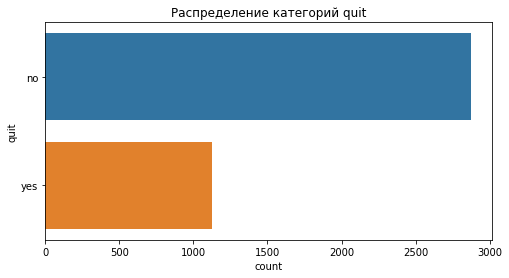

--------------------------------------------------


In [84]:
analyze_categorical_features(X_train_2,['quit'])

Числовые данные для quit:


no     1436
yes     564
Name: quit, dtype: int64

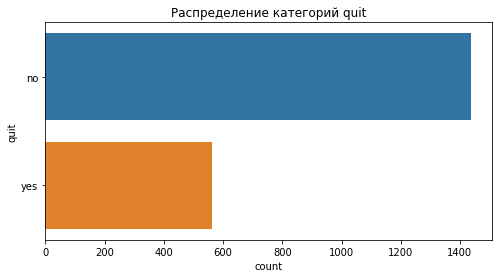

--------------------------------------------------


In [85]:
analyze_categorical_features(y_test_2,['quit'])

### Вывод: есть дисбаланс целевого признака. Пропроции в тестовой / тренировочной выборке соблюдены.

In [86]:
X_train_2.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [87]:
#Количественные 
quant_features = [
    'salary'
    
]

In [88]:
# Категориальные 
cat_features = [
    'dept',
    'last_year_promo',
    'last_year_violations',
    'level',
    'workload'
]


In [89]:
discrete_features = [
    'supervisor_evaluation',
    'employment_years'
]

In [90]:
#Добавлю обновленную функцию прям здесь и посмотрим на распределение
def analyze_numerical_features2(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика для признака: {feature}")
        display(df[feature].describe())

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Нормированная гистограмма
        axes[0].set_title(f'Нормированное распределение {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Плотность')

        if target:
            sns.histplot(data=df, x=feature, hue=target, kde=True, stat='density', common_norm=False, bins=20, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, stat='density', common_norm=False, bins=20, ax=axes[0])

        # Boxplot
        axes[1].set_title(f'Boxplot для {feature}', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, x=feature, ax=axes[1])

        plt.tight_layout()
        plt.show()
        print("-" * 60)

📊 Статистика для признака: salary


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

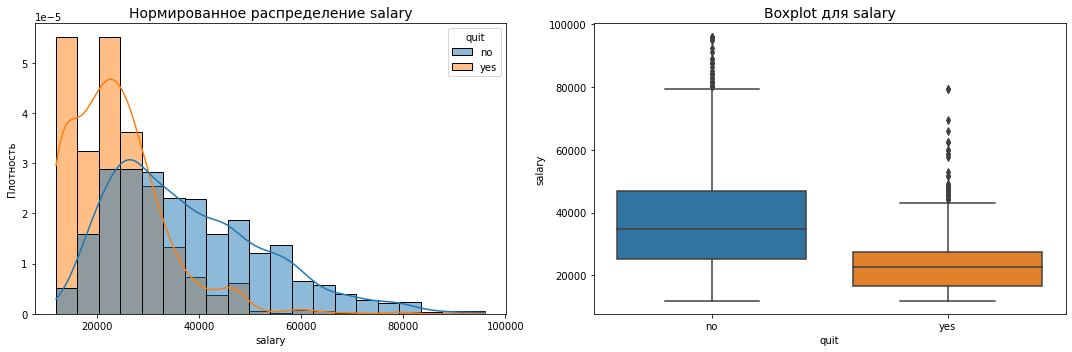

------------------------------------------------------------


In [91]:
analyze_numerical_features2(X_train_2, quant_features,'quit')

📊 Статистика для признака: salary


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

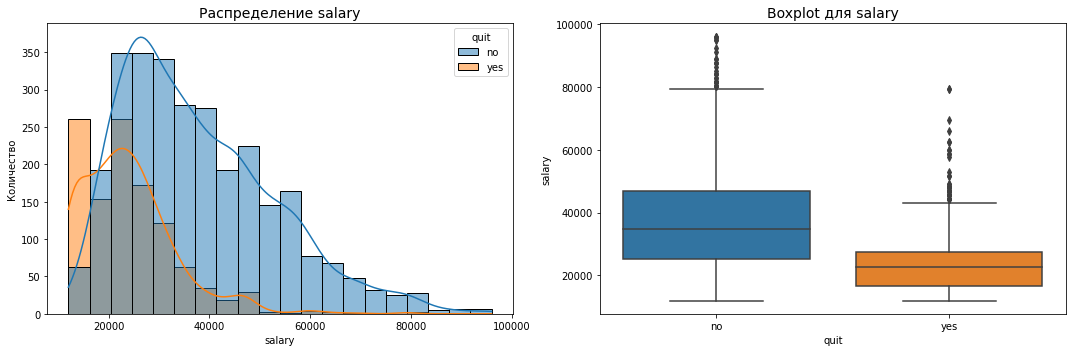

------------------------------------------------------------


In [92]:
analyze_numerical_features(X_train_2, quant_features,'quit')

In [96]:
# Аналогично добавлю сюда второй вариант функции для дискретных велечин 
def analyze_discrete_features2(df, features, target):
    for feature in features:
        print(f"📊 Нормализованная статистика по признаку: {feature}")
        display(df[feature].value_counts(normalize=True).sort_index())

        fig, ax = plt.subplots(figsize=(10, 5))

        # Считаем доли target по каждой категории признака
        data = (
            df.groupby(feature)[target]
            .value_counts(normalize=True)
            .unstack()
            .fillna(0)
            .sort_index()
        )

        data.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')
        ax.set_title(f'Доли {target} по значениям признака {feature}', fontsize=14)
        ax.set_ylabel('Доля')
        ax.set_xlabel(feature)
        ax.legend(title=target)
        plt.tight_layout()
        plt.show()
        print("-" * 60)


📊 Статистика по дискретному признаку: supervisor_evaluation


1     202
2     391
3    1233
4    1654
5     520
Name: supervisor_evaluation, dtype: int64

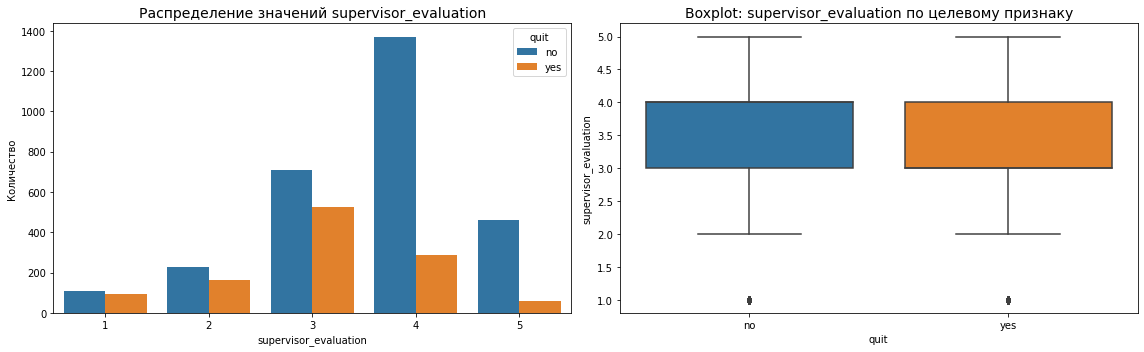

------------------------------------------------------------
📊 Статистика по дискретному признаку: employment_years


1     985
2     777
3     479
4     393
5     362
6     296
7     308
8     174
9     136
10     90
Name: employment_years, dtype: int64

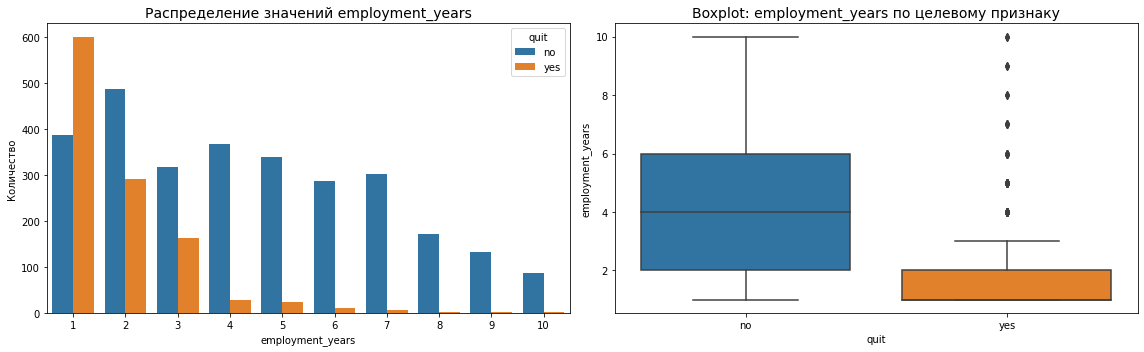

------------------------------------------------------------


In [94]:
analyze_discrete_features(X_train_2,discrete_features,'quit')

📊 Нормализованная статистика по признаку: supervisor_evaluation


1    0.05050
2    0.09775
3    0.30825
4    0.41350
5    0.13000
Name: supervisor_evaluation, dtype: float64

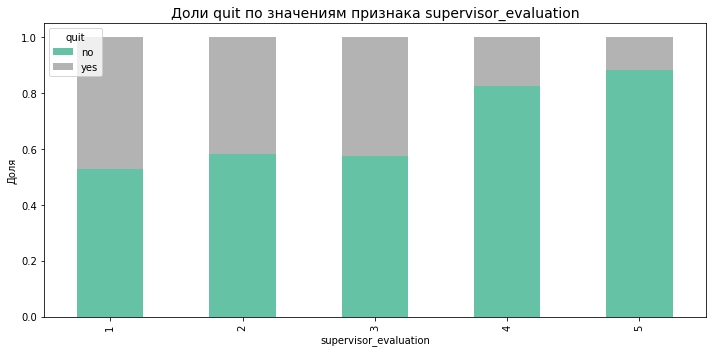

------------------------------------------------------------
📊 Нормализованная статистика по признаку: employment_years


1     0.24625
2     0.19425
3     0.11975
4     0.09825
5     0.09050
6     0.07400
7     0.07700
8     0.04350
9     0.03400
10    0.02250
Name: employment_years, dtype: float64

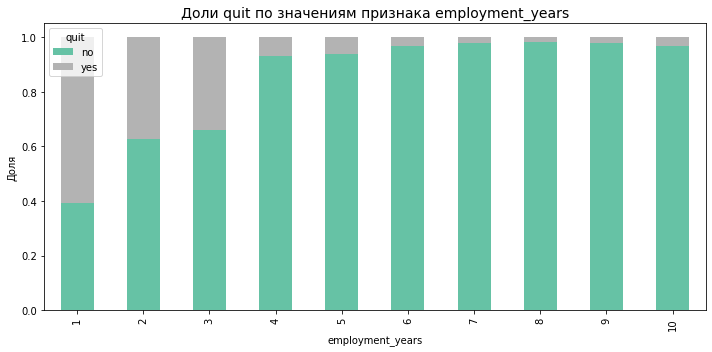

------------------------------------------------------------


In [97]:
analyze_discrete_features2(X_train_2,discrete_features,'quit')

In [ ]:
# на этом этапе я понимаю, что в ф-ции для категориальных данных мне не хватает целевого 
# чтож, правим
def analyze_categorical_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика по категориальному признаку: {feature}")
        display(df[feature].value_counts())
        print()

        fig, axes = plt.subplots(1, 2, figsize=(16, 5))

        # График распределения категорий
        if target:
            sns.countplot(data=df, y=feature, hue=target,
                          order=df[feature].value_counts().index,
                          ax=axes[0])
            axes[0].set_title(f"Распределение {feature} по {target}", fontsize=14)
        else:
            sns.countplot(data=df, y=feature,
                          order=df[feature].value_counts().index,
                          ax=axes[0])
            axes[0].set_title(f"Распределение категорий {feature}", fontsize=14)
        
        axes[0].set_xlabel("Количество")
        axes[0].set_ylabel(feature)

        # Таблица долей по целевому признаку
        if target:
            ctab = pd.crosstab(df[feature], df[target], normalize='index').round(3)
            ctab.plot(kind='barh', stacked=True, ax=axes[1], colormap='Set2')
            axes[1].set_title(f"Доли {target} внутри {feature}", fontsize=14)
            axes[1].set_xlabel("Доля")
            axes[1].set_ylabel("")
        else:
            axes[1].axis('off')  # если нет target, второй график не нужен

        plt.tight_layout()
        plt.show()
        print("-" * 60)


In [ ]:
analyze_categorical_features(X_train_2, cat_features,'quit')


### Выводы по исследовательскому анализу
- Зарплата у тех кто увольняется меньше. Это хорошо видно по смещенной влево вершине, а так же по более узкой и нихзкой медиане диаграммы размаха.
- По оценке визуально нельзя сделать вывод, диаграммы размаха идентичны, а '1' и там и там является выбросом.
- Хорошо видно, что большинство сотрудников увольняется в первые два года. И совсем редко те, кто в компании более трех лет.
- По количеству, чаще всего уходят из продаж, чуть меньше из тех. отдела. Остальные отделы примерно одинаково.
- Вообще не уходят те, кого повысили.
-  В большинстве случаев уходят джуны, очень редко мидлы и совсем редко синьоры. 
- Одинаково часто уходят люди со средней загрузкой и с низкой. И редко уходят те, кто сильно загружен. 

### Посмотрим на зависимость между job_satisfaction_rate и quit

In [ ]:
# добавим в тестовую выборку 
X_test_2['job_satisfaction_rate']=y_test
X_test_2['quit'] = y_test_2['quit']
X_test_2

Необходимо понять есть ли зависимость между уровнем удовлетворенности сотрудника и его желанием уволиться. Для этого проверим равны ли средние значения уровня удовлетворенности для каждой из групп.

Сформулируем нулевую гипотезу Н0: средние уровени удовлетворенности уволившихся и оставшихся сотрудников равны.

Альтернативная гипотеза будет выглядеть следующим образом: средние уровени удовлетворенности уволившихся и оставшихся сотрудников не равны (двусторонняя гипотеза Н1).

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам будем использовать метод st.ttest_ind(array1, array2, equal_var, alternative), поскольку данные выборки являются независимыми.

📊 Статистика для признака: salary


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

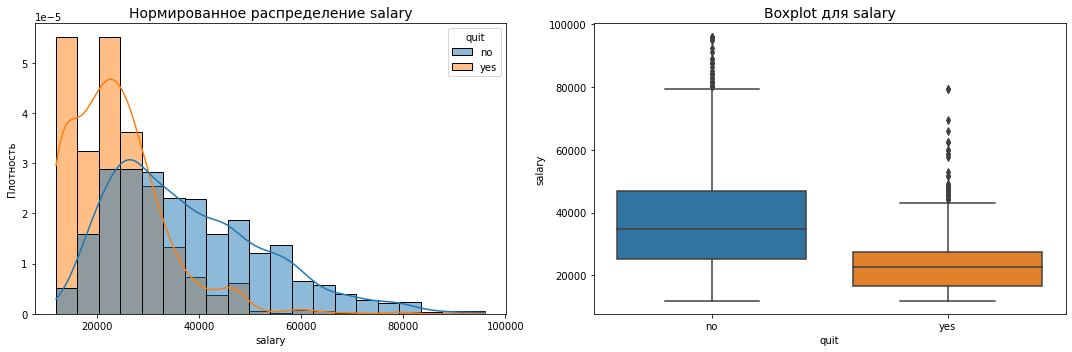

------------------------------------------------------------


In [100]:
analyze_numerical_features2(X_train_2, quant_features,'quit')

📊 Статистика для признака: salary


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

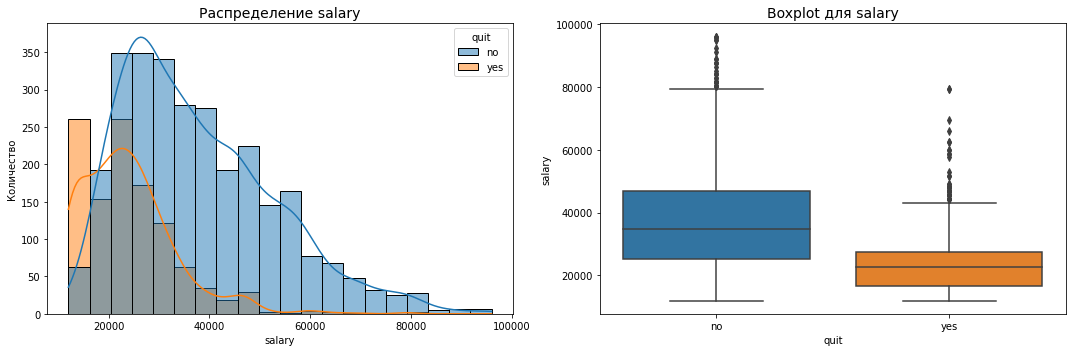

------------------------------------------------------------


In [99]:
analyze_numerical_features(X_train_2, quant_features,'quit')

In [ ]:

#проверка гипотезы 
alpha = 0.05 #уровень значимости 

results = stats.ttest_ind(X_test_2.query('quit == "no"')['job_satisfaction_rate'], 
                       X_test_2.query('quit == "yes"')['job_satisfaction_rate']) 

In [ ]:
print('Средний уровень удовлетворённости уволившегося сотрудника:', round(X_test_2.query('quit == "yes"')['job_satisfaction_rate'].mean(), 2))
print('Средний уровень удовлетворённости оставшегося сотрудника:', round(X_test_2.query('quit == "no"')['job_satisfaction_rate'].mean(), 2))
print('p-значение:', results.pvalue)

if results.pvalue < alpha: #проверка p_value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

### Вывод
- Визуально хорошо видно, как вершины уволившихся сотрудников смещены влево, а тех кто остался вправо.
- На диаграмме размаха так же видно, что медиана уволившихся ниже, чем тех, кто остался. Хотя и там и там есть выбросы. 
- Отвергая нулевую гипотезу, мы действительно можем предположить, что у уволившихся сотрудников был меньший уровень удовлетворенности, чем у оставшихся.
- p-значение близко к нулю, это говорит о сильном эфекте. 
- Так как есть связь, то необходимо добавить результаты работы первой модели к входным данным этой задачи.

### Дополнение к выводу после нормализации гистограмм:
- Есть две вершины в распределении ушедших сотрудников по зарплате: меньше 20к и чуть больше 20к. Дале еидет на спад. После salary выше 50к практически никто не увольняется. Возможно все то меньше 20-25к это общепринятый прожиточный минимум, а все что выше 50к это уже комфорт и в связи с этим, люди остаются. 
- Хорошо видно, что чаще уходят те, у кого оценки ниже 4х. Возможно есть система мотивации, привязанная  к оценкам. Что мотивирует сотрудников оставаться в компаннии. 
- Так же хорошо видно, что доля сотрудников ушедших в первый год 0,6. Во 2ой и 3ий - по 0,4,. И далее количество уходящих становится совсем маленьким. Я бы предложил проанализировать тех, кто работает на позициях с большой текучнкой. Если это начинающие специалисты после ВУЗов, то им необходимо сделать более прозрачный карьерный путь и понятные условия для роста, что бы удержать в компании. 

## Добавление нового входного признака 
В тренировочных данных отсутсвует этот признак, поэтому мы возьмем лучшую модель и предскажем их.

In [ ]:
#Забекапимся 
X_train_2_copy = X_train_2


### В тренировочной выборке у нас нет job_satisfaction_rate_pred, поэтому мы его предскажем. При этом в тестовой выборке он есть, там ничего добавлять не надо.

In [ ]:
X_train_2['job_satisfaction_rate']=randomized_search.predict(X_train_2)
X_train_2

In [ ]:
#Захотелось посмотреть распределение 
analyze_numerical_features(X_train_2, ['job_satisfaction_rate'],'quit')

#### Визуально хорошо видно, что до значения 0,6, там чаще увольняются в 50% и более. После ощутимо меняется статистика. Можно сделать этот признак категориальным со значением 0.6. Пока оставлю как есть, но если мне не понравится результат, обязательно вернусь. 


## Подготовка данных
Необходимо корректно разбить данные на тестовые и тренировочные, а так же осуществить предобработку  в пайплайне. Так как у нас задача логистической регрессии, перебирать будем 4 модели МО: 
- Логистическую регрессию
- Метод опорных векторов
- Метод ближайших соседей
- Дерево решений 

Для оценки качества, в соответсвии с брифом будем использовать ROC-AUC.


In [ ]:
#ввыделяем целевой
y_train_2 = X_train_2['quit']

In [ ]:
#убираем id и целевой
X_train_2=X_train_2.drop(['id','quit'],axis=1)

In [ ]:
y_test_2 = X_test_2['quit']

In [ ]:
# ранее мы соединяли тесовый в единый, теперь разъединяем
X_test_2 = X_test_2.drop(['id','quit'],axis=1)

In [ ]:
X_test_2.head()

In [ ]:
y_test_2.head()

In [ ]:
#кодирование целевого признака
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

In [ ]:
#создание списков количественных и категориальных для пайплайна
# по факту мы просто добавляем job_satisfaction_rate в количественные 
num_col_2 = ['employment_years',  
           'salary',
          'job_satisfaction_rate']

ord_col_2 = ['level',
           'workload',
           'supervisor_evaluation']

ohe_col_2 = ['dept',
           'last_year_promo', 
           'last_year_violations']



In [ ]:
#Pipeline для кодирования категориальных признаков
ohe_pipe_2 = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

In [ ]:
#Pipeline для кодирования категориальных ранговых признаков
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5]
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [ ]:
# Pipeline для подготовки данных
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_col_2),
        ('ord', ord_pipe_2, ord_col_2),
        ('num', StandardScaler(), num_col_2)
    ], 
    remainder='passthrough'
)

In [ ]:
# Итоговый Pipeline: подготовка данных и модель
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', LinearRegression())
])

In [ ]:
#Параметры для передачи GridSearchCV/RandomizedSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder и перебором гиперпараметров

param_grid_2 = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

## Обучение модели 

In [ ]:
# Поиск рандомом:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
randomized_search_2.fit(X_train_2, y_train_2)

In [ ]:

print('Метрика ROC-AUC для лучшей модели:\n', round(randomized_search_2.best_score_, 2)) 
print('\nЛучшая модель и её параметры:\n\n', randomized_search_2.best_params_) 

In [ ]:
# Можно собрать датафрейм и посмотреть на все результаты 
# Наша метрика в столбце mean_test_score, отрицательная она потому что
# greater_is_better=False 
pd.DataFrame(randomized_search_2.cv_results_).sort_values('rank_test_score')

In [ ]:
y_pred_2 = randomized_search_2.predict_proba(X_test_2)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_2, y_pred_2[:, 1]), 2)}')

In [ ]:

#поиск важных признаков
X_encoded_2 = randomized_search_2.best_estimator_['preprocessor'].fit_transform(X_train_2)

model_2 = randomized_search_2.best_estimator_['models'].fit(X_encoded_2, y_train_2)
explainer_2 = shap.PermutationExplainer(model_2, X_encoded_2)


labels_2 = randomized_search_2.best_estimator_[:-1].get_feature_names_out()

plt.title('Оценка важности признаков')
plt.ylabel('Признаки')
shap.summary_plot(X_encoded_2, plot_type='bar', feature_names=labels_2) 

### Выводы по второй задаче:
- Лучшая модель - SVC (метод опорных векторов)
- Ее метрика на тестовых данных ROC-AUC = 0.93,  что соответствует условию задачи. 
- Самым весомым признаком получилась оценка руководителя. Что дает гипотезу, на тему того, что руководство понимает и оценивает сотрудников адекватно. 


## Общий вывод
В рамках данного проекта решались две задачи:
1. Предсказание уровня удовлетворенности сотрудника
2. Предсказание увольнения сотрудника из компании




### Что было сделано по первой задаче:
####  Осуществлена загрузка 3х датасетов с данными о сотрудниках компании и первоначальное знакомство с ними

#### Проведена предобработка данных:
- Ознакомились с данными
- Убедились что типы данных во всех столбцах соответствуют действительности
- Убедились что названия столбцов соотеветсвуют общепринятым правилам;
- Посмотрели что нет полных дублей и точечных дублей по id.
- Нашли 4 + 2 пропуска, заменили их с помощью пайплайна(SimpleImputer) на самое популярное значение.

#### Проведен исследовательский анализ данных, в рамках его:
- Познакомились с данными визуально, как с категориальными, так и с количественными, и количественными, которые имеют дискретную природу. 
- Распределения нормальные, подозрений не вызывают. 

#### Провели корреляционный анализ:
- Мультиколлинеарность не обнаружена
- Тк датасет не большой, оставили все признаки, даже с маленькой корреляцией.

#### Собрали пайплайн данных
##### Осуществили подготовку данных

##### Использовали модели: 
- Линейной регрессии
- Дерево решений


##### Действовали по плану:
- Разделим данные на тренировочную и тестовую выборки.
- Подготовим данные: отдельно обработаем количественные, отдельно категориальные, отдельно ранговые. 
- Масштабируем данные
- Обучим модель, посмотрим метрики, выберем самую эффективную модель.

##### По итогу:
- Мы перебрали 2 модели(LinearRegression, DecisionTreeRegressor)
- Лучшая модель: дерево решений с глубиной 13 и масштабированием количественных признаков через StandardScaler().
- Следуя условию задачи, мы написали собственную метрику SMAPE и на тестовой выборке она равна 14.52, что так же соответствует условию задачи(<=15)
- Самым весомым признаком оказался ord__supervisor_evaluation. Хотя изначально у меня была логическая ошибка, что я отнес его к количественным признакам. После исправления ничего не поменялось, что объясняется тем, что у нас дерево, которое не зависит от этого порядка.
- Логике признак тоже поддается, если руководитель ставит хорошую оценку, значит его устраивает как работает сотрудник.
- Второй по знакчимости признак employment_years, что тоже поддается логике: если человек долго работает, то его все устраивает.
- Предполагаю, что дерево справилось лучше, так как есть нелинейные зависимости.


### Что было сделано по второй задаче:
#### Важное замечание, датасет с тестовой выборкой остался тем же, просто поменялся целевой признак.  Поэтому мы анализировали тренировочную выборку с учетом распределения целевого признака. 

####  Осуществлена загрузка 3х датасетов с данными о сотрудниках компании и первоначальное знакомство с ними

#### Проведена предобработка данных:
- Ознакомились с данными
- Убедились что типы данных во всех столбцах соответствуют действительности
- Убедились что названия столбцов соотеветсвуют общепринятым правилам;
- Посмотрели что нет полных дублей и точечных дублей по id.


#### Проведен исследовательский анализ данных, в рамках его:
- Познакомились с данными визуально, как с категориальными, так и с количественными, и количественными, которые имеют дискретную природу с учетом распределения целевого признака. 
- Распределения нормальные, подозрений не вызывают.
#### Выводы по исследовательскому анализу
- Зарплата у тех кто увольняется меньше. Это хорошо видно по смещенной влево вершине, а так же по более узкой и нихзкой медиане диаграммы размаха.
- По оценке визуально нельзя сделать вывод, диаграммы размаха идентичны, а '1' и там и там является выбросом.
- Хорошо видно, что большинство сотрудников увольняется в первые два года. И совсем редко те, кто в компании более трех лет.
- По количеству, чаще всего уходят из продаж, чуть меньше из тех. отдела. Остальные отделы примерно одинаково.
- Вообще не уходят те, кого повысили.
- В большинстве случаев уходят джуны, очень редко мидлы и совсем редко синьоры.
- Одинаково часто уходят люди со средней загрузкой и с низкой. И редко уходят те, кто сильно загружен.

#### Добавили в тестовую выборку результаты решения первой задачи, провели исследование и сделали выводы:
- Визуально хорошо видно, как вершины уволившихся сотрудников смещены влево, а тех кто остался вправо.
- На диаграмме размаха так же видно, что медиана уволившихся ниже, чем тех, кто остался. Хотя и там и там есть выбросы.
- Отвергая нулевую гипотезу, мы действительно можем предположить, что у уволившихся сотрудников был меньший уровень удовлетворенности, чем у оставшихся.
- p-значение близко к нулю, это говорит о сильном эфекте.
- Так как есть связь, то необходимо добавить результаты работы первой модели к входным данным этой задачи.

#### Собрали пайплайн данных
#####  Определили, что у нас задача логистической регрессии, решили что перебирать будем 4 модели МО:
- Логистическую регрессию
- Метод опорных векторов
- Метод ближайших соседей
- Дерево решений

##### Так как в  тренировочной выборке у нас не было job_satisfaction_rate , поэтому мы его предскажем. При этом в тестовой выборке он есть, там ничего добавлять не надо. 

##### Действовали по плану:
- Разделим данные на тренировочную и тестовую выборки.
- Закодируем в пайплайне целевой признак.
- Подготовим данные: отдельно обработаем количественные, отдельно категориальные, отдельно ранговые. 
- Масштабируем данные
- Обучим модель, посмотрим метрики, выберем самую эффективную модель.

##### Обучили модель и сделали выводы по второй задаче:
- Лучшая модель - SVC (метод опорных векторов)
- Ее метрика на тестовых данных ROC-AUC = 0.93,  что соответствует условию задачи. 
- Самым весомым признаком получилась оценка руководителя. Что дает гипотезу, на тему того, что руководство понимает и оценивает сотрудников адекватно. 



## Итоговый вывод для бизнеса:
- Большая текучка характера для уровня джуниоров и в первый год. 
- Однако если в этот же год сделать повышение, то увольнение можно избежать.

